#Solving QUBOs with Qiskit-Optimization QAOA

Date: December 4th, 2023

The notebook contains materials supporting the tutorial paper:
*Five Starter Problems: Solving QUBOs on Quantum Computers* by Arul Rhik Mazumder (arulm@andrew.cmu.edu) and Sridhar Tayur (stayur@cmu.edu).
It depends on various packages shown below.

### **Introduction**

Qiskit-Optimization is a part of IBM Qiskit's open source quantum computing framework. It provides easy, high-level applications of quantum algorithms that can run on both classical and quantum simulators. It provides a wide array of algorithms and built-in application classes for NP-Hard problems. For this paper, we only focus on QAOA and ignore the built-in application classes to take advantage of its docplex modelling capabilities. By defining custom QUBOs instead of relying on predefined classes, users can more easily implement and solve their own QUBO models using qiskit-opimization.

Qiskit-Optimization is an extremely useful and easy way to solve QUBOs with various quantum algorithms including Variational Quantum Eigensolver, Adaptive Grovers and the earlier mentioned QAOA. Furthermore, because of compatibility with IBMQ, algorithms can run on actual IBM quantum backends. In the examples below, all code is run by default on the Qiskit QASM simulator. Although base level implementation is easier, customization and indepth analysis are more difficult. Tasks like plotting optimization history or bitstring distributions, although possible, are significantly more challenging. Qiskit-Optimization's key limitations are its extremely long optimization times and limited set of optimizers.  It is very slow in solving QUBOs with over 10 variables and was measured to take almost 45 minutes for a QUBO with only 18 variables, however accurate. Furthermore, there is a defined set optimizers shown below:

https://qiskit.org/documentation/stubs/qiskit.algorithms.optimizers.html

Although the set of local and global optimizers is pretty expansive, it is difficult to use any optimizer not<!-- now?-->. Thus, it is impossible to implement many promising algorithms such as Adagrad and Genetic Algorithm as classical optimizers.

Using Qiskit Runtime further customization such as error mitigation, custom ansatz circuits, and custom cost hamiltonians is possible, but requires more advanced knowledge. More information is provided in the link below:

https://qiskit.org/ecosystem/optimization/tutorials/12_qaoa_runtime.html

In [1]:
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

if IN_COLAB:
 !pip install -q qiskit==0.39.2
 !pip install -q qiskit-optimization==0.5.0
 print("All Packages Installed!")

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.2/19.2 MB 18.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.4/240.4 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.4/39.4 MB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 929.7/929.7 kB 29.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 25.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.5/107.5 kB 5.5 MB/s

In [2]:
# Problem Modelling Imports
from qiskit_optimization.converters.quadratic_program_to_qubo import QuadraticProgramToQubo
from qiskit_optimization.translators import from_docplex_mp
from docplex.mp.model import Model

# Qiskit Optimizer Imports
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit.algorithms.minimum_eigensolvers import QAOA
from qiskit.algorithms.optimizers import SPSA, COBYLA, NELDER_MEAD

from qiskit.primitives import Sampler

# Misc. Imports
import time
import matplotlib.pyplot as plt

### **Example 1 - Number Partitioning Problem**

In [3]:
test_1 = [1, 7, 10, 18]
test_2 = [11, 29, 21, 17, 32, 10]
test_3 = [25, 7, 13, 31, 42, 17, 21, 10]

In [4]:
arr = test_2
n = len(arr)
c = sum(arr)

**Number Partitioning Models**

Given an array of $n$ integers $[a_{1}, a_{2}, a_{3} ... a_{n}]$, the corresponding Ising Hamiltonian is

$$H=(\sum_{i=1}^{n}a_{i}s_{i})^2$$

where $s_{i} \in \{-1,1\}$ is the Ising spin variable.

Similarly, the corresponding QUBO Model is

$$Q=(\sum_{i=1}^{n}a_{i}-2\sum_{i=1}^{n}a_{i}x_{i})^{2}$$
or
$$Q=(c-2\sum_{i=1}^{n}a_{i}x_{i})^{2}$$

where $c=\sum_{i=1}^{n}a_{i}$ and $x_{i} \in \{0, 1\}$ is a binary quadratic variable.

In [5]:
model = Model()
x = model.binary_var_list(n)
Q = (c - 2*sum(arr[i]*x[i] for i in range(n)))**2
model.minimize(Q)
problem = from_docplex_mp(model)
qubo = QuadraticProgramToQubo().convert(problem)

**Solving the QUBO**

This algorithm uses the Simultaneous Perturbation Stochastic Approximation (SPSA) optimizers. It is one of the gradient-free optimization algorithms offered by Qiskit-Optimization and is well suited for uncertain or noisy objective functions. In this, SPSA is run for a maximum of 250 iterations.

The sampler references the base sampler used by Qiskit. This sampler finds the probability of bitstring solutions. Finally, the QAOA uses the optimizer and sampler to create the quantum circuit to run on the QASM Simulator. You can further specify the number of reps, which describes the number of iterations of cost and mixer hamiltonians. In this example and all following circuits, this has been set to $p=2$.

The Minimum Eigen Optimizer converts the QUBO problems to the Ising Model and then solves it using the quantum circuit defined before.


In [6]:
spsa = SPSA(maxiter=250)
sampler = Sampler()
qaoa = QAOA(sampler=sampler, optimizer=spsa, reps=2)
algorithm = MinimumEigenOptimizer(qaoa)

In [7]:
result = algorithm.solve(problem)
#print(result.prettyprint())
elapsed_time = result.min_eigen_solver_result.optimizer_time

In [8]:
# Converting the output binary variables to produce a valid output
def partition(binary_dict):
    P1 = []
    P2 = []
    for key, value in binary_dict.items():
        if value == 0:
            P1.append(arr[int(key[1:])])
        elif value == 1:
            P2.append(arr[int(key[1:])])
    sum1 = sum(P1)
    sum2 = sum(P2)
    if print is not None:
      print(P1)
      print('Sum: ' + str(sum1))
      print(P2)
      print('Sum: ' + str(sum2))
    return abs(sum1 - sum2)

In [9]:
partition(result.variables_dict)
print("Optimization Time: " + str(elapsed_time))

[29, 21, 10]
Sum: 60
[11, 17, 32]
Sum: 60
Optimization Time: 29.009896993637085


### **Example 2 - Max-Cut Problem**

In [10]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

In [11]:
def draw_graph(G, colors, pos):
    default_axes = plt.axes()
    nx.draw_networkx(G, node_color=colors, node_size=600, alpha=0.8, ax=default_axes, pos=pos)
    edge_labels = nx.get_edge_attributes(G, "weight")

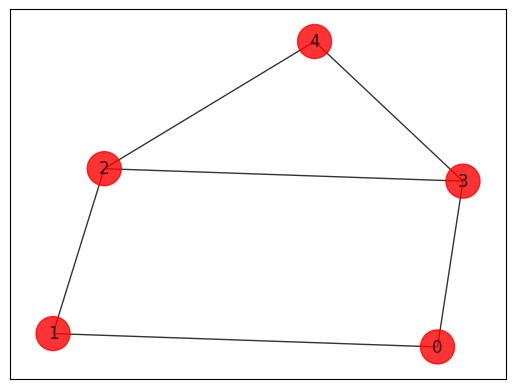

In [12]:
# Generating a graph of 4 nodes

n = 5  # Number of nodes in graph
G = nx.Graph()
G.add_nodes_from(np.arange(0, n, 1))
edges = [(0, 1, 1.0), (0, 3, 1.0), (1, 2, 1.0), (2, 3, 1.0), (2, 4, 1.0), (3, 4, 1.0)]
# tuple is (i,j,weight) where (i,j) is the edge
G.add_weighted_edges_from(edges)

colors = ["r" for node in G.nodes()]
pos = nx.spring_layout(G)

draw_graph(G, colors, pos)

**Max-Cut Models**

Given an undirected unweighted Graph $G$ with vertex set $V$ and edge set $E$ with edges $(i, j)$, the corresponding Ising Hamiltonian is

$$H=\sum_{(i, j) \in E}\frac{1-s_{i}s_{j}}{2}$$

where $s_{i} \in \{-1,1\}$ is the Ising spin variable.

The corresponding QUBO Model is

$$Q=\sum_{(i, j)\in E}(x_{i}+x_{j}-2x_{i}x_{j})$$

where $x_{i} \in \{0, 1\}$ is a binary quadratic variable.

In [13]:
model = Model()
x = model.binary_var_list(n)
H = sum(2*x[e[0]]*x[e[1]] - x[e[0]] - x[e[1]] for e in edges)
model.minimize(H)
problem = from_docplex_mp(model)
qubo = QuadraticProgramToQubo().convert(problem)

**Solving the QUBO**

Other than the features shared with the Number Partitioning Partition, this algorithm uses the Constrained by Linear Approximation (COBYLA) optimizers. It is another gradient-free optimization algorithm offered by Qiskit-Optimization. It is similarly run for 250 iterations and is one of the most popularly used QAOA optimizers due to its tradeoff of speed and accuracy.

In [14]:
cobyla = COBYLA(maxiter=250)
sampler = Sampler()
qaoa = QAOA(sampler=sampler, optimizer=cobyla, reps=2)
algorithm = MinimumEigenOptimizer(qaoa)

In [15]:
result = algorithm.solve(problem)
print(result.prettyprint())
elapsed_time = result.min_eigen_solver_result.optimizer_time
print("Optimization Time: " + str(elapsed_time))

objective function value: -5.0
variable values: x0=1.0, x1=0.0, x2=1.0, x3=0.0, x4=0.0
status: SUCCESS
Optimization Time: 4.466760635375977


Optimization Time: 4.466760635375977


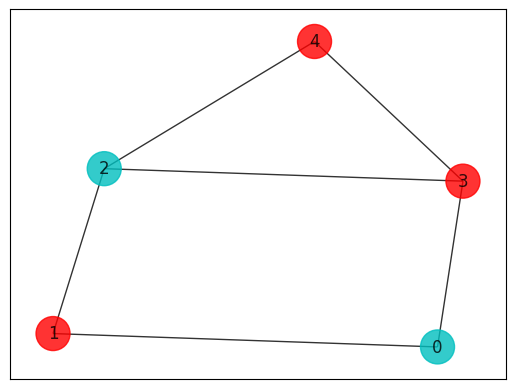

In [16]:
# Converting the output binary variables to produce a valid output
colors = ["r" if result.variables_dict[v] == 0.0 else "c" for v in result.variables_dict.keys()]
draw_graph(G, colors, pos)
print("Optimization Time: " + str(elapsed_time))

### **Example 3 - Minimum Vertex Cover**

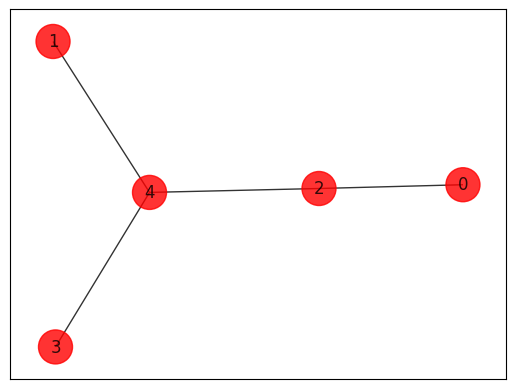

In [17]:
# Generating a graph of 4 nodes

n = 5  # Number of nodes in graph
G = nx.Graph()
G.add_nodes_from(np.arange(0, n, 1))
edges = [(0, 2, 1.0), (2, 4, 1.0), (1, 4, 1.0), (3, 4, 1.0)]
# tuple is (i,j,weight) where (i,j) is the edge
G.add_weighted_edges_from(edges)

colors = ["r" for node in G.nodes()]
pos = nx.spring_layout(G)

draw_graph(G, colors, pos)

**Minimum Vertex Cover Models**

Given an undirected, unweighted Graph $G$ with vertex set $V$ with vertices $i$ and edge set $E$ with edges $(i, j)$, the corresponding Ising Hamiltonian is

$$H=P\sum_{(i, j) \in E}(1-s_{i})(1-s_{j}) + \sum_{i \in V}s_{i}$$

where $s_{i} \in \{-1,1\}$ is the Ising spin variable and $P$ is the penalty coefficient.

The corresponding QUBO Model is

$$Q=\sum_{i \in V}x_{i} + P(\sum_{(i, j) \in E}(1-x_{i}-x_{j}+x_{i}x_{j}))$$

where $x_{i} \in \{0, 1\}$ is a binary quadratic variable.

Note that in the example, $P$ was chosen through trial-and-error, although there exist rigorous mathematical processes.

In [18]:
model = Model()
x = model.binary_var_list(n)
P = 10
H = sum(x[i] for i in range(n)) + P*sum(1 - x[e[0]] - x[e[1]] + x[e[0]]*x[e[1]] for e in edges)
model.minimize(H)
problem = from_docplex_mp(model)
qubo = QuadraticProgramToQubo().convert(problem)

**Solving the QUBO**

Other than the features shared with the Number Partitioning Partition, this algorithm uses the Nelder optimizers. It is another gradient-free optimization algorithm offered by Qiskit-Optimization. This algorithm is great for solving nondifferentiable, nonlinear, and noisy functions by iterative evolving a simplex and is similarly run for 250 iterations.

In [19]:
nelder_mead = NELDER_MEAD(maxiter=250)
sampler = Sampler()
qaoa = QAOA(sampler=sampler, optimizer=nelder_mead, reps=2)
algorithm = MinimumEigenOptimizer(qaoa)

In [20]:
result = algorithm.solve(problem)
print(result.prettyprint())
elapsed_time = result.min_eigen_solver_result.optimizer_time
print("Optimization Time: " + str(elapsed_time))

objective function value: 2.0
variable values: x0=1.0, x1=0.0, x2=0.0, x3=0.0, x4=1.0
status: SUCCESS
Optimization Time: 3.1786155700683594


Execution Time: 3.1786155700683594


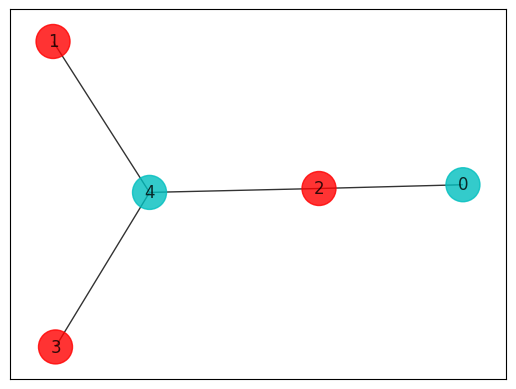

In [21]:
# Converting the output binary variables to produce a valid output
colors = ["r" if result.variables_dict[v] == 0.0 else "c" for v in result.variables_dict.keys()]
draw_graph(G, colors, pos)
print("Execution Time: " + str(elapsed_time))